In [1]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

colors = ['#1F77B4', '#AEC7E8', '#FF7F0E', '#FFBB78', '#2CA02C', '#98DF8A', '#B5CF6B', '#FF9896','#9467BD', '#C5B0D5', '#BCBD22']

# Part 1 – Data Preparation and Preprocessing 

## 1.1 Dataset Description 

In [2]:
df = pd.read_csv("data.csv")

C:\Users\dilsh\AppData\Local\Temp\ipykernel_27356\3477112522.py:1: DtypeWarning: Columns (0,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv")


### 1.1.1 Attributes 
The dataset contains 318,477 job postings with 13 attributes each. The attributes are as follows: 
![image.png](attachment:4f9691ce-a874-41f9-bf72-e6d25d8b7375.png)

The attributes Title, Requirement and full description have many unique values. Because they are categorical attributes, they may not have much predictive power. The ID attribute is only a unique identifier for each row, and so won’t be used. The attributes location, area, classification and subclassification have a lot of null values which will be difficult to deal with. Simply discarding them isn’t a valid option as that would significantly reduce the amount of data to work with. They have fewer unique values which improves predictive power of the attributes, and are all categorical. The salary attributes all have 11 unique values which means they could be classified as continuous or categorical. There are some advantages for using categorical, such as better predictive power when using KNN. Area and Location are similar, and further investigation into those attributes show only a few of the unique values have a high percentage of representation, as seen in the below figure 1. It may be beneficial to remove one.

In [3]:
print("The Dataset consists of: ", df.shape[0], " rows and ", df.shape[1], " columns")

The Dataset consists of:  318477  rows and  13  columns


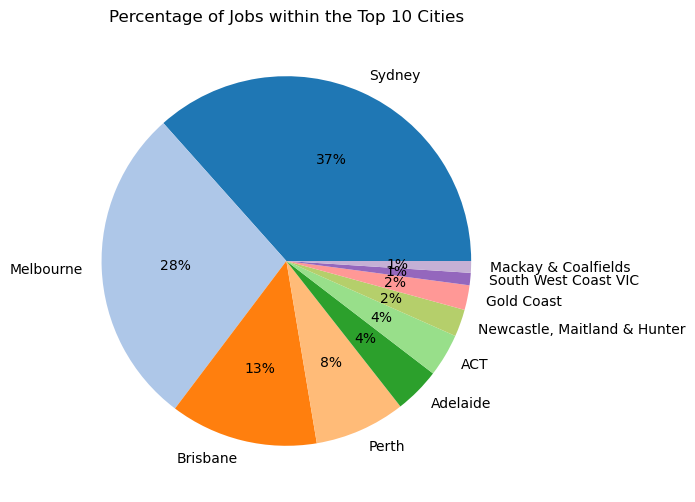

In [4]:
locationDf = df[df['Location'].isna()==False]
locationDf = locationDf.groupby('Location').count()
locationDf['Location'] = locationDf.index
locationDf['Count'] = locationDf["Title"]
locationDf = locationDf.sort_values(by=["Count"], ascending =False)
locationTop10Df = locationDf[:10].copy()
plt.figure(figsize=(8,6))
plt.title("Percentage of Jobs within the Top 10 Cities")
plt.pie(locationTop10Df["Count"], labels=locationTop10Df['Location'], colors=colors, autopct='%.0f%%')
plt.show()

The attributes to be used include location, area, classification, lowest salary, and highest salary. These attributes have low unique values, and so have lower dimensionality improving predictive power and computational cost. Some other values that will be considered are Date, company and subclassification. Date may be important to analyse because of the seasonal effect on the data, and subclassification has few enough unique values that it may be useful in analysis. Company can show if some types of companies regularly post job postings which may indicate high employee turnover or high demand for a specific role. The attributes Title, requirement, full description and ID will not be used. Title, requirement and full description can include large bodies of text which don’t have any particular use in analysis and are hard to draw conclusions from. ID is a unique identifier and doesn’t provide any use in analysis, and so will be removed. 

# 1.2 Dataset Preprocessing steps

In [5]:
#Removal of the ID column as it is not needed
df.drop('Id', axis=1, inplace=True)

In [6]:
#Checks data types
df.dtypes

Title                object
Company              object
Date                 object
Location             object
Area                 object
Classification       object
SubClassification    object
Requirement          object
FullDescription      object
LowestSalary          int64
HighestSalary         int64
JobType              object
dtype: object

In [7]:
#Convert Date data type to datetime
df["Date"] = df["Date"].replace(to_replace=r'T.*', value='', regex=True)
df["Date"] = pd.to_datetime(df["Date"])
df.dtypes

Title                        object
Company                      object
Date                 datetime64[ns]
Location                     object
Area                         object
Classification               object
SubClassification            object
Requirement                  object
FullDescription              object
LowestSalary                  int64
HighestSalary                 int64
JobType                      object
dtype: object

In [8]:
#Duplicate Data
dup_data = df[df.duplicated()].shape[0] 
print("Amount of Duplicates within Data:", dup_data)

Amount of Duplicates within Data: 8607


In [9]:
#Duplicate Data with different dates
no_ddf = df.drop('Date', axis=1)
no_date_dup_data = no_ddf[no_ddf.duplicated()].shape[0] 
print("Amount of Duplicates within Data:", no_date_dup_data-dup_data)

Amount of Duplicates within Data: 6724


In [10]:
#Removes all duplicates including 
df = df.drop_duplicates(subset=df.columns.difference(['Date']))

In [11]:
#Add a average salary column
df = df.assign(AverageSalary=(df['HighestSalary']+ df['LowestSalary'])/2)
df["AverageSalary"] = df["AverageSalary"].astype(int)

In [12]:
df.count()

Title                303146
Company              291296
Date                 303146
Location             192095
Area                 119152
Classification       192095
SubClassification    192095
Requirement          303139
FullDescription      287738
LowestSalary         303146
HighestSalary        303146
JobType              287810
AverageSalary        303146
dtype: int64

In [13]:
df.isnull().sum()

Title                     0
Company               11850
Date                      0
Location             111051
Area                 183994
Classification       111051
SubClassification    111051
Requirement               7
FullDescription       15408
LowestSalary              0
HighestSalary             0
JobType               15336
AverageSalary             0
dtype: int64

In [14]:
#Percentage of Missing Data for each Column
per = (df.isnull().sum()/df.shape[0])*100
for_per = per.map('{:.2f}%'.format)
print(for_per)

Title                 0.00%
Company               3.91%
Date                  0.00%
Location             36.63%
Area                 60.69%
Classification       36.63%
SubClassification    36.63%
Requirement           0.00%
FullDescription       5.08%
LowestSalary          0.00%
HighestSalary         0.00%
JobType               5.06%
AverageSalary         0.00%
dtype: object


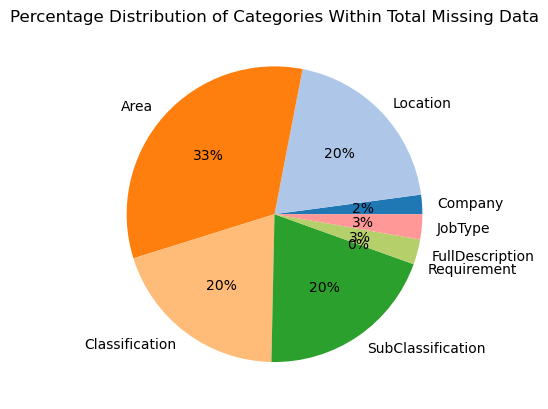

In [15]:
#This is not total missing data but their percentages within the missing data
per_nozero = per[per != 0]
plt.pie(per_nozero, labels=per_nozero.index, colors=colors, autopct='%.0f%%')
plt.title("Percentage Distribution of Categories Within Total Missing Data")
plt.show()

In [16]:
#Drop Area
df.drop('Area', axis=1, inplace=True)

The data containing the information required to be analysed and processed is conveniently contained in a excel spreadsheet labelled “data.csv”. The data is capable of being transferred into a DataFrame using the pandas function “read_csv()”. 

**Irrelevant Data**

- The data column labelled “ID”, does not contain any useful information that can be extracted throughout analysis; thus, the column has been removed from the DataFrame. This column was likely used to differentiate between job postings on the SEEK website.
- The data column labelled “Area”, refers to a specific area within the job’s current location. Due to 60% of the column’s data being missing and the insignificances of the information that can be extracted from the data. Thus, the column has been removed from the DataFrame. The data provided from the location column provides the necessary information needed to complete the analysis.

**Duplicate Data**

- Within in the dataset, there are 8607 duplicates each containing identical information. As the inclusion of this data will cause the analysis to contain bias, the duplicates will be removed from the DataFrame.
- In addition, job’s posting can contain identical information although be posted on different dates. The number of duplicates with different dates totals to 6724. As this data also collaborates to creating bias within the analysis, these duplicates will also be removed.

**Missing Data**

- The columns containing the most amount of missing data consist of Area, Location, Classification and Sub-classification. As area is mainly used to specify specific areas within a location, its absent does not have as much impact to the analysis in comparison to the other columns.
- Analysis involving Location, Classification and Sub-classification will only contain data without any missing information to any misrepresentation of the data.
- The remaining columns with a small amount of missing data will not involving analysis without them as the amount is considered within a reasonable amount.

**Additional Data**

- An additional column was added to the DataFrame labelled as “AverageSalary”. This column is used to represent the range between a job posting’s highest and lowest salary. Avoiding the need to complete analysis between both types of salaries.



## 1.3 Hypothesis 

The goal of this report is to analyse the SEEK job market data and evaluate the findings. The topics we are investigating include:
- Which job sectors are more popular in which cities
- the seasonal effect on job postings
- Ranges of salaries across each city
- what ist he market share of each sector, and are there any dominant sub-sectors
- trends in the market over time

These topics will help the evaluation of the current markets. It will help identify which areas of the market that need balancing. 

The predictions are as follows:- Information and Communication Technology will be the largest growing sector in the top 5 major cities but not the largest sectors in smaller cities
- There are more job postings during the first 2 quarters of the year with significantly less postings in the last 2 quarters of the year
- Salaries will be highest in more populated cities and lower in less populated cities
- The market share of any IT related sectors will be most dominant, followed by trades and healthcare.
- Trends will show an increase of IT, healthcare, and trades and a decrease in self-employment, management, call centres and mining.

# Part 2 - Data Analysis and Interpretation

## 2.1 Job Metadata

### 2.1.1 Job Classification Analysis

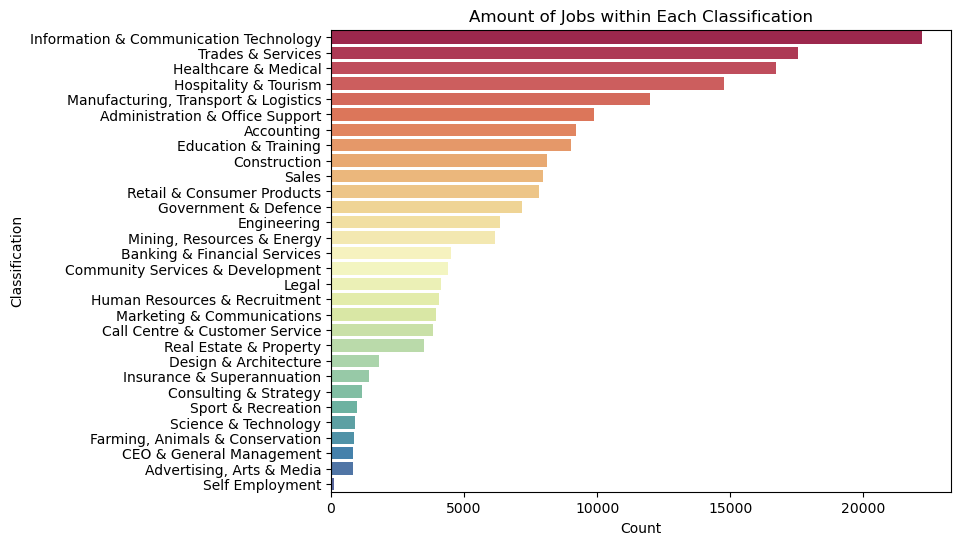

In [17]:
classDf = df[df['Classification'].isna()==False]
classDf = classDf.groupby('Classification').count()
classDf['Classification'] = classDf.index
classDf['Count'] = classDf["Title"]
classDf.sort_values("Count", ascending=False, inplace=True)
plt.figure(figsize=(8,6))
sns.barplot(data=classDf, x="Count", y="Classification", hue="Classification", palette='Spectral')
plt.title("Amount of Jobs within Each Classification")
plt.show()

In [18]:
print("The Dataset contains a total of:", df["SubClassification"].unique().shape[0], "subclassifications")

The Dataset contains a total of: 339 subclassifications


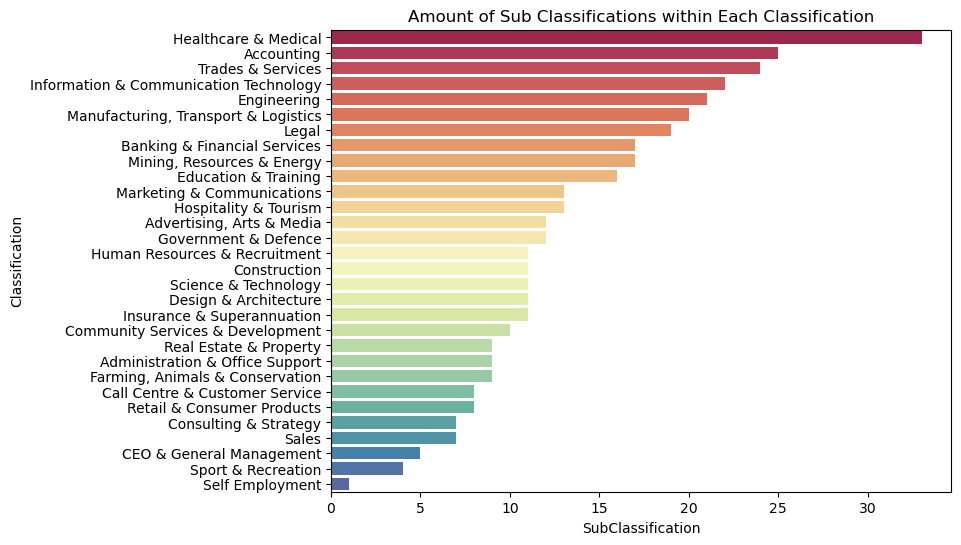

In [19]:
subinclassdf = df.groupby("Classification")["SubClassification"].nunique()
subinclassdf.sort_values(ascending=False, inplace=True)
subinclassdf = subinclassdf.reset_index()
plt.figure(figsize=(8,6))
sns.barplot(data=subinclassdf, x="SubClassification", y="Classification", hue="Classification", palette='Spectral')
plt.title("Amount of Sub Classifications within Each Classification")
plt.show()

**Observations**

**Classifications**

- There are 30 types of classifications within the dataset
- The classifications containing the highest of job postings consists of Information & Communication Technology, Trades & Services, Healthcare & Medical, Hospitality & Tourism
- Self-Employment, Sports & Recreation and CEO & General Management represent classifications with the lowest amount of job postings

**Sub-Classification**

- There consist of 339 different sub-classifications in total each separated within different classifications
- The number of sub-classifications within each classification closely relates to the amount of total job postings in classifications. As classifications that hold a higher amount of sub classifications also hold a higher amount of job postings. Although there are a few outlier such as accounting, engineering and legal.

### 2.1.2 Job Location Analysis

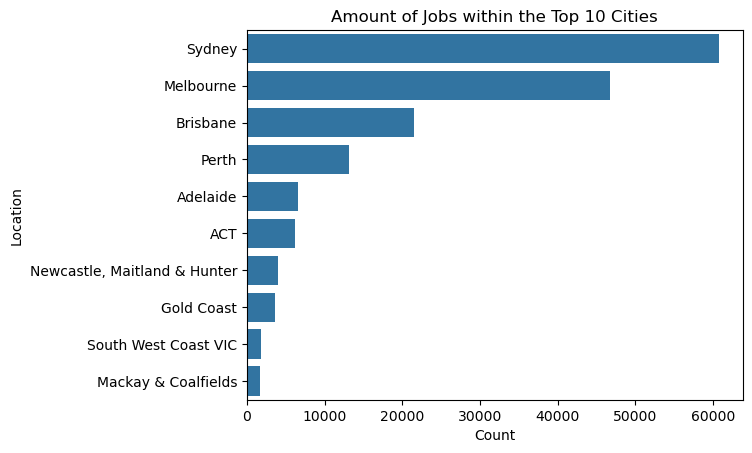

In [20]:
plt.title("Amount of Jobs within the Top 10 Cities")
sns.barplot(data=locationTop10Df, y="Location", x="Count")
plt.show()

As expected, there are a significantly larger number of job postings on cities with higher populations. There are a couple of outliers, one of which is ACT which has significantly less population than Adelaide but has higher job postings. This is likely due to the strong government presence there requiring more jobs as policies change and the country develops. Some other notable deviances from the rule include Melbourne and Sydney, and Newcastle, Maitland, hunter and gold coast. Melbourne has higher population than Sydney, but less job postings. The Newcastle, Maitland and hunter group also have higher population than gold coast, but significantly fewer job postings compared to their relative population. 

### 2.1.3 Job Salary Range Analysis

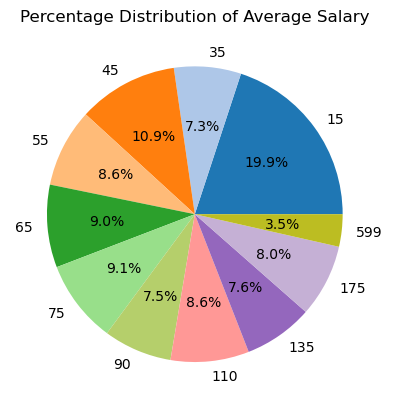

In [21]:
salarydata = df['AverageSalary'].value_counts().reset_index()
salarydata.columns = ["AverageSalary", "Count"]
salarydata = salarydata.sort_values(by=["AverageSalary"], ascending =True)

plt.pie(salarydata["Count"], labels=salarydata['AverageSalary'], autopct='%1.1f%%', colors=colors)
plt.title("Percentage Distribution of Average Salary")
plt.show()

The job salary range is even across the board except for the 599k band and the 15k band. There are significantly more jobs offered at 15k p.a. on job postings. This is due to jobs from casual retail which are targeted towards teenagers and young adults. They typically have high turnover and high demand while the nature of the job means the employee are not working many hours a week, and therefore not making as much salary. The 599k band of 3.5% is expected as these are very high-end jobs, requiring specialist training to be valid for the job. 

## 2.2 Market By Locations

### 2.2.1 Market Size of Each City

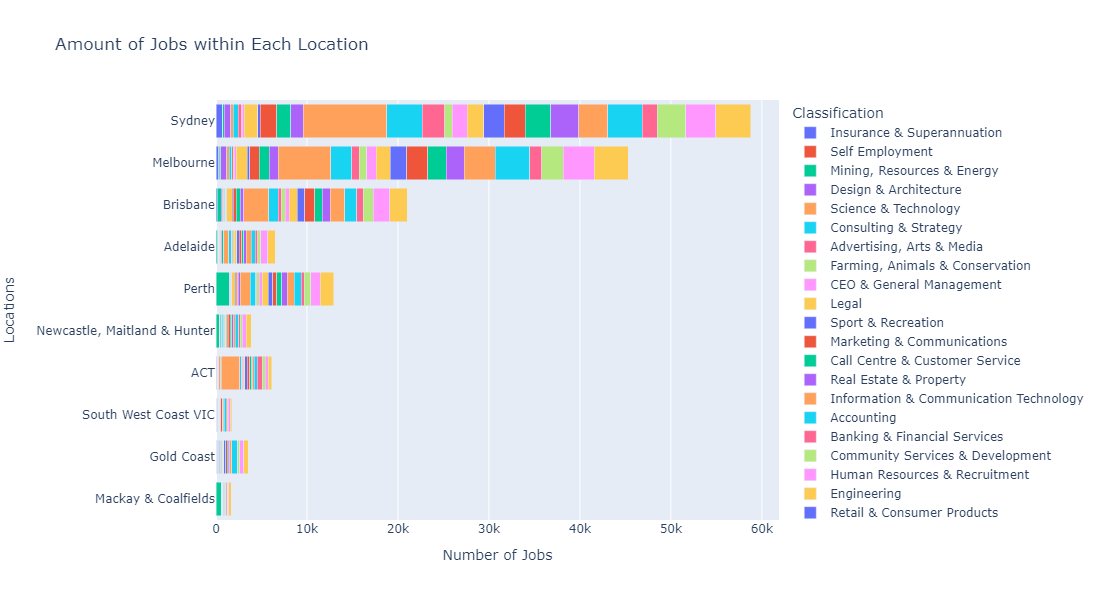

In [22]:
top10location = locationDf.head(10)
mergedf = pd.merge(df, top10location[['Count']], left_on='Location', right_index=True)
lcdf = mergedf.groupby(['Location', 'Classification']).size().reset_index(name='Count')
lcdf = lcdf.sort_values(by='Count', ascending=True)

fig = px.bar(lcdf, y='Location', x='Count', color='Classification', title='Amount of Jobs within Each Location',
             labels={'Count': 'Number of Jobs', 'Location': 'Locations', 'Classification': 'Classification'}, barmode='stack')

fig.update_layout(height=600,  width=1150)
fig.show()

In Sydney, Melbourne, Brisbane, Perth and Act, the classification ”science & technology” is the largest sector. Especially ACT, likely due to government presence and the centralization of contractors. Over the last 5 years the government have been trying to diversify tech locations so Canberra is not so reliant on Sydney and Melbourne tech infrastructure. In all other cities, science and technology do not have a large market share and are underrepresented in some cases. Sydney and Melbourne have much more hospitality and tourism due to the cities’ attraction for tourists. Gold Coast has hospitality and tourism as the highest classification, which is high for the population. Trades & services have the next largest market share, which is common among all cities. Trades & services are a requirement of living which explains their prevalence in all locations regardless of population. Healthcare and Medical is similar but has less of a requirement in comparison, likely due to the specifications required to work in healthcare and medical. Perth has a high mining, resources and energy sector presence, as does Mackay & Coalfields. Sydney and Melbourne also have this sector but this is not unusual as many mining and energy companies have headquarters in these areas. 

### 2.2.2 Job Salary Range Per City in Top 10 Cities

C:\Users\dilsh\AppData\Local\Temp\ipykernel_27356\1390399702.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




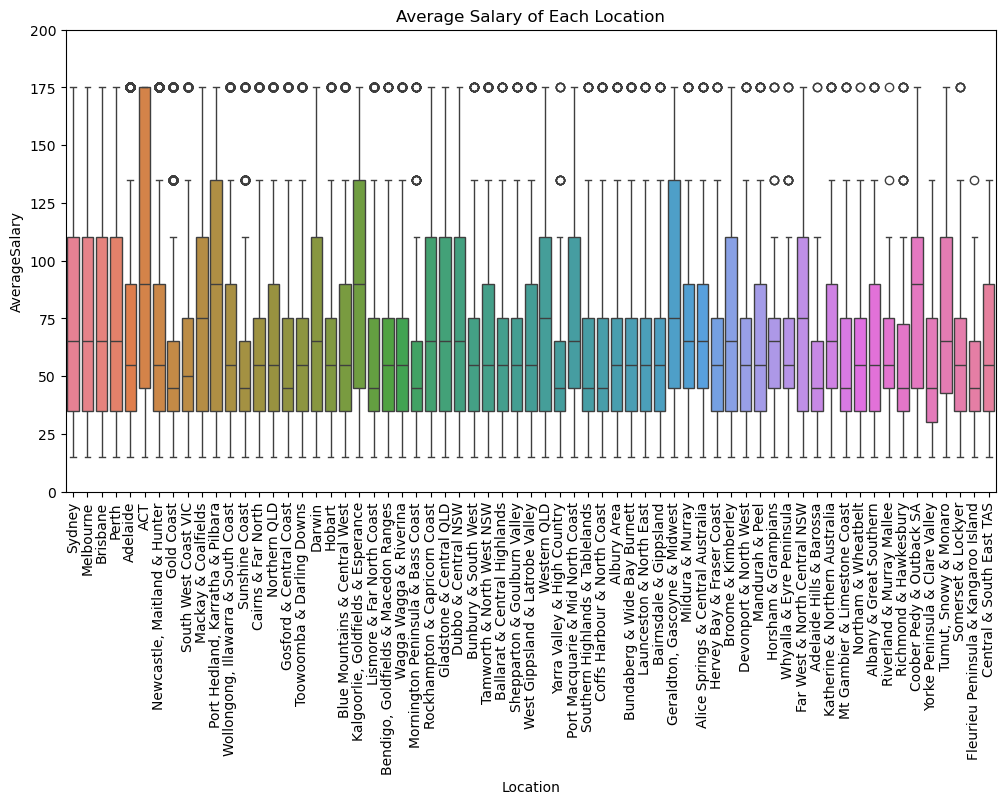

In [23]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="Location", y="AverageSalary", order=locationDf["Location"], palette=sns.color_palette("husl", 65))
plt.ylim(0, 200)
plt.xticks(rotation=90)
plt.title("Average Salary of Each Location")
plt.show()

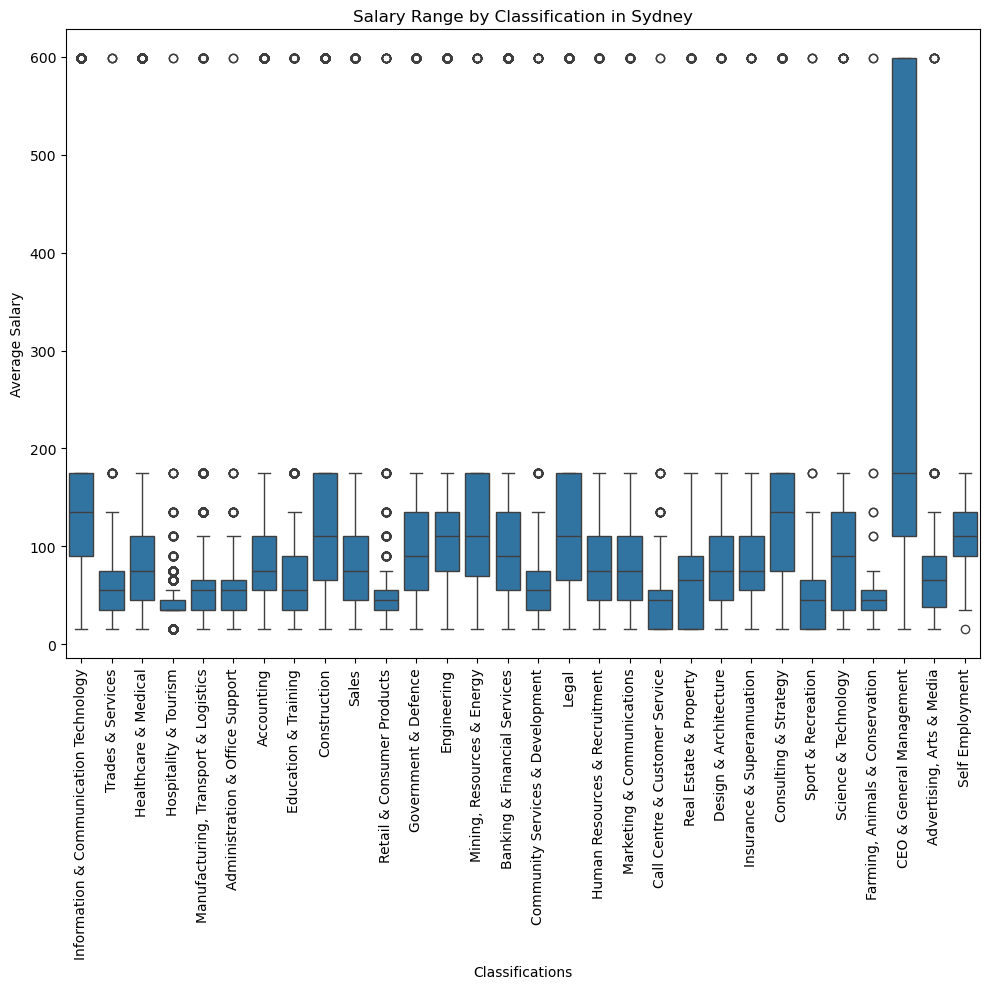

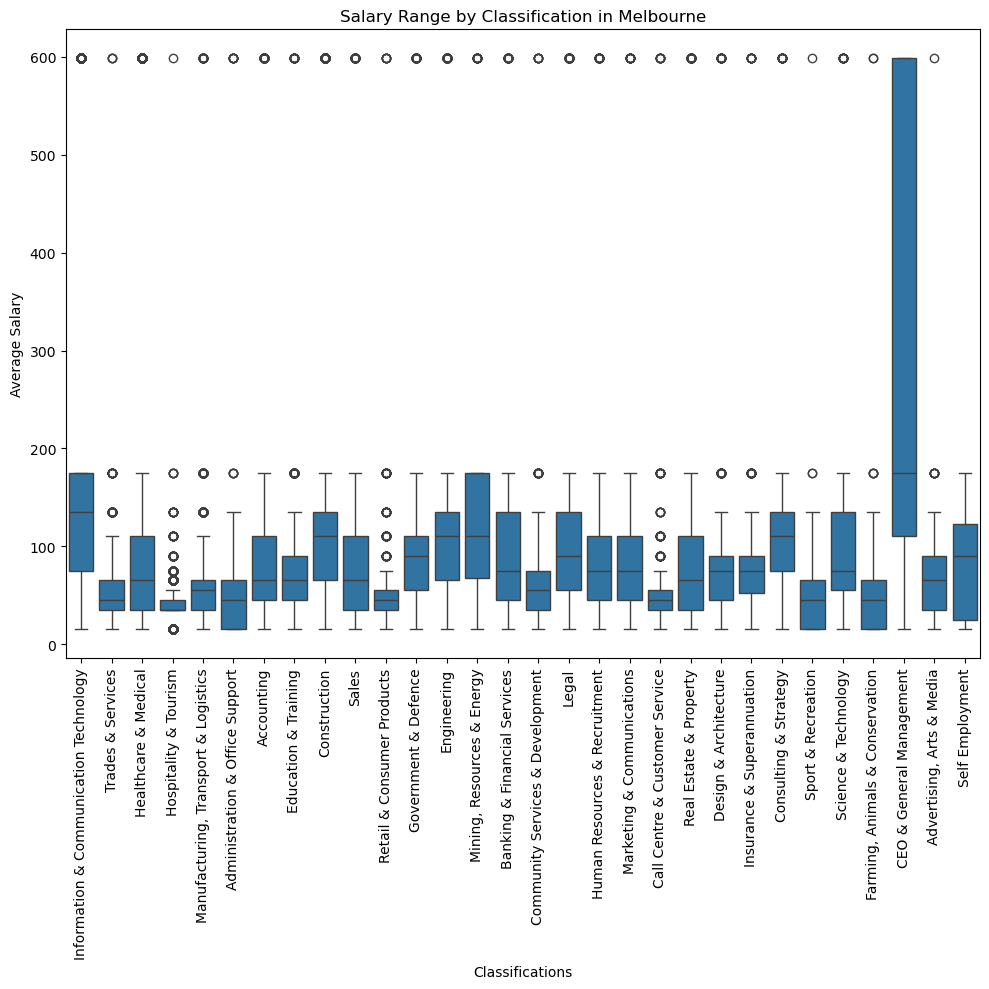

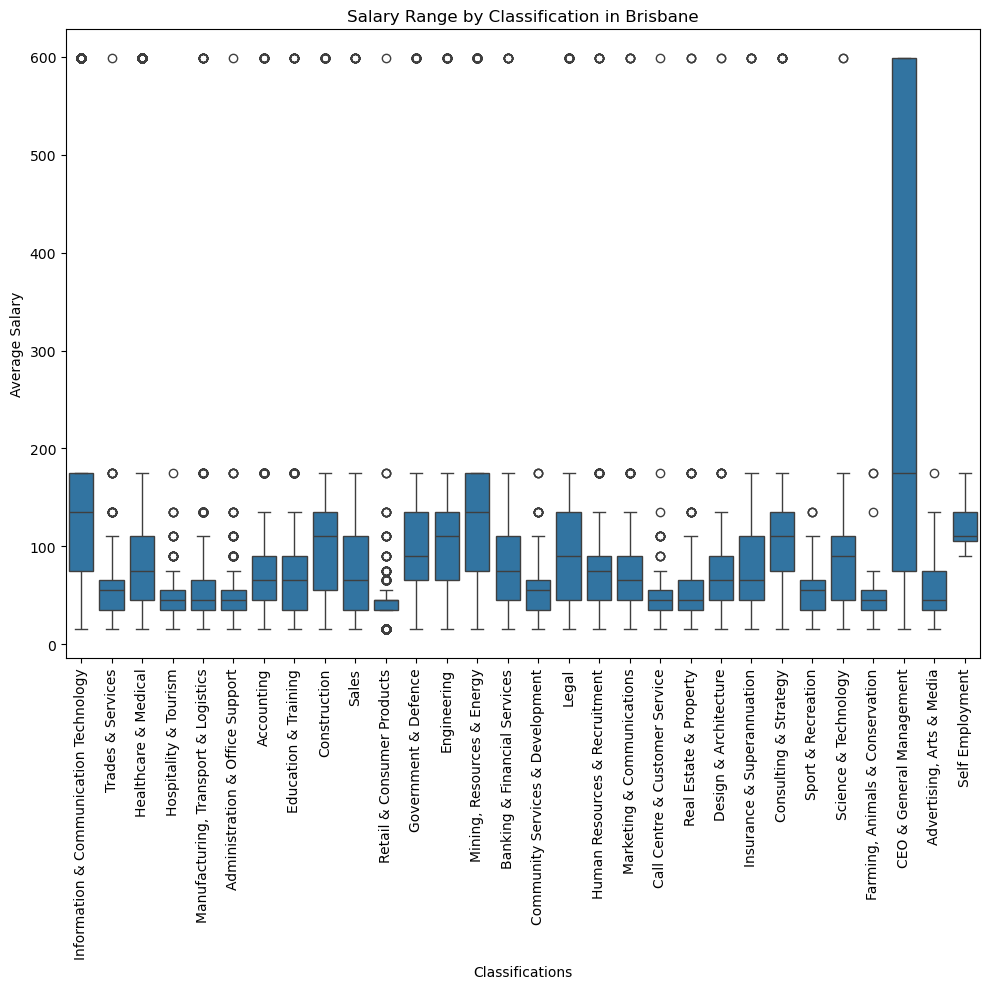

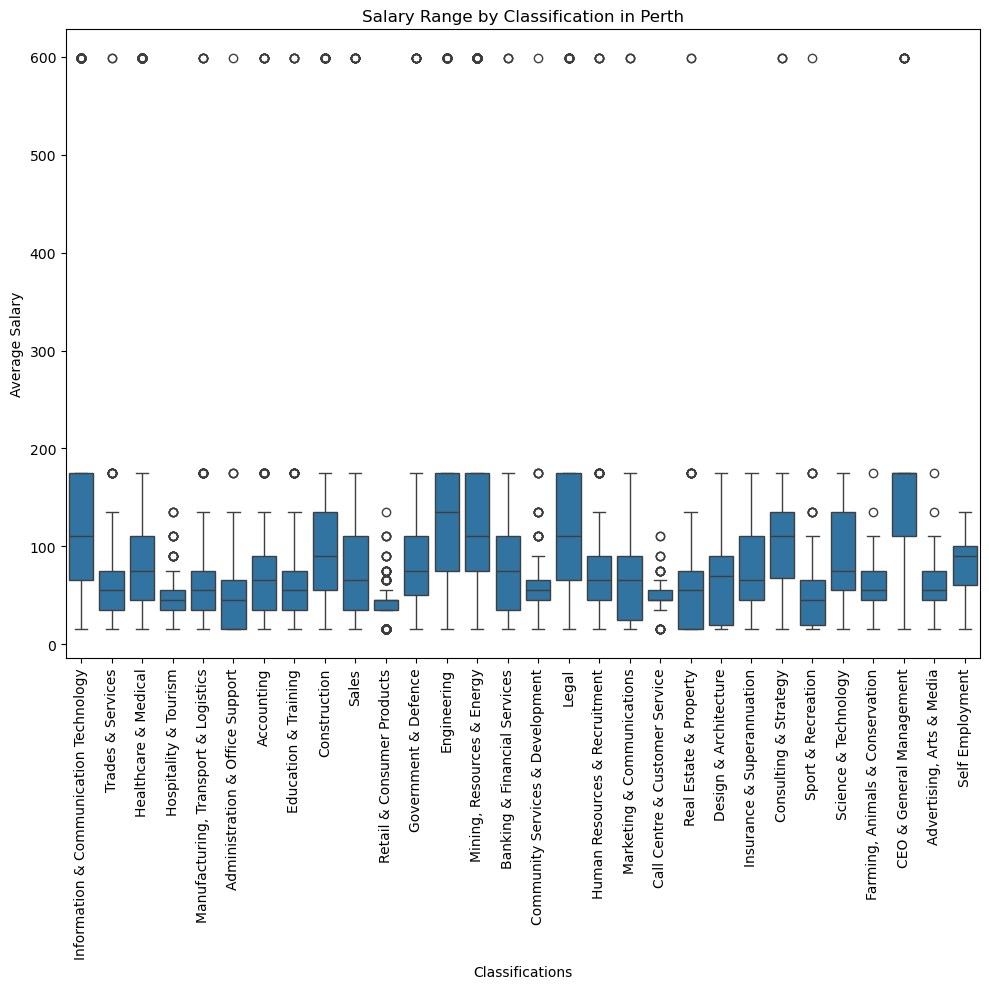

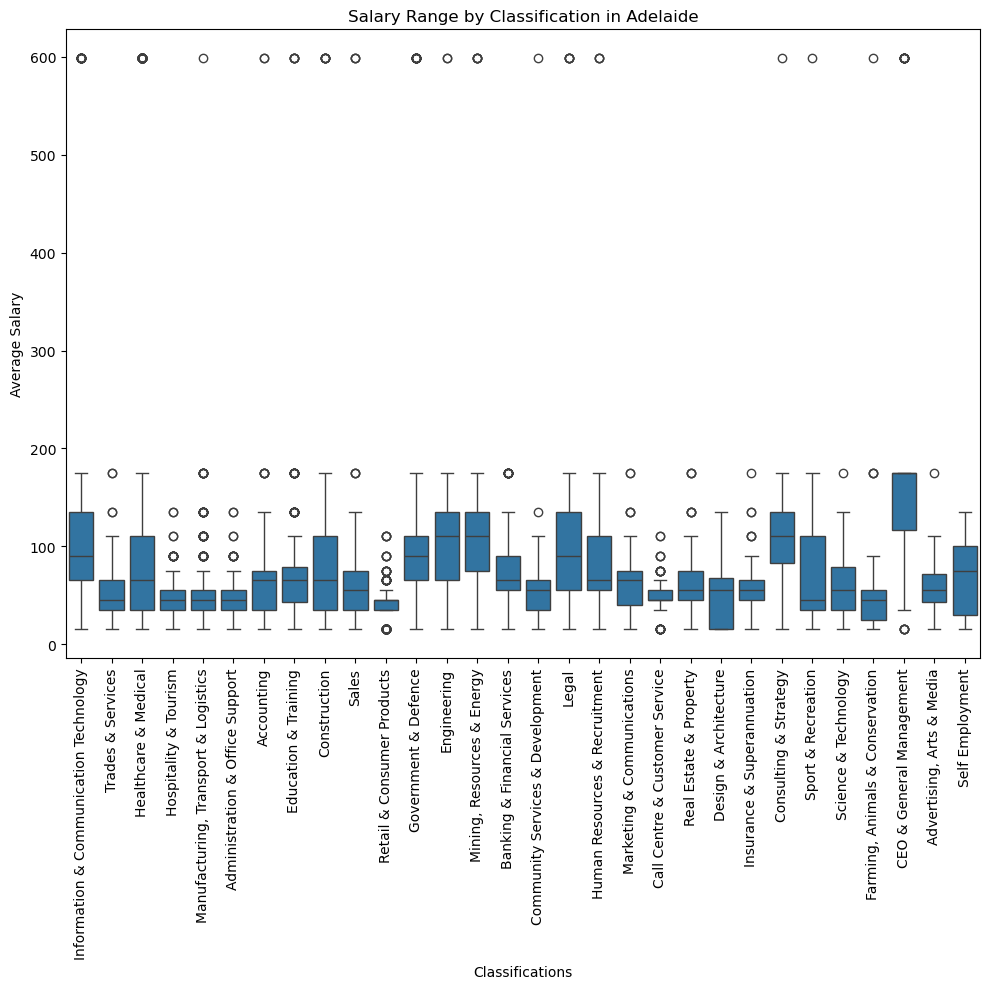

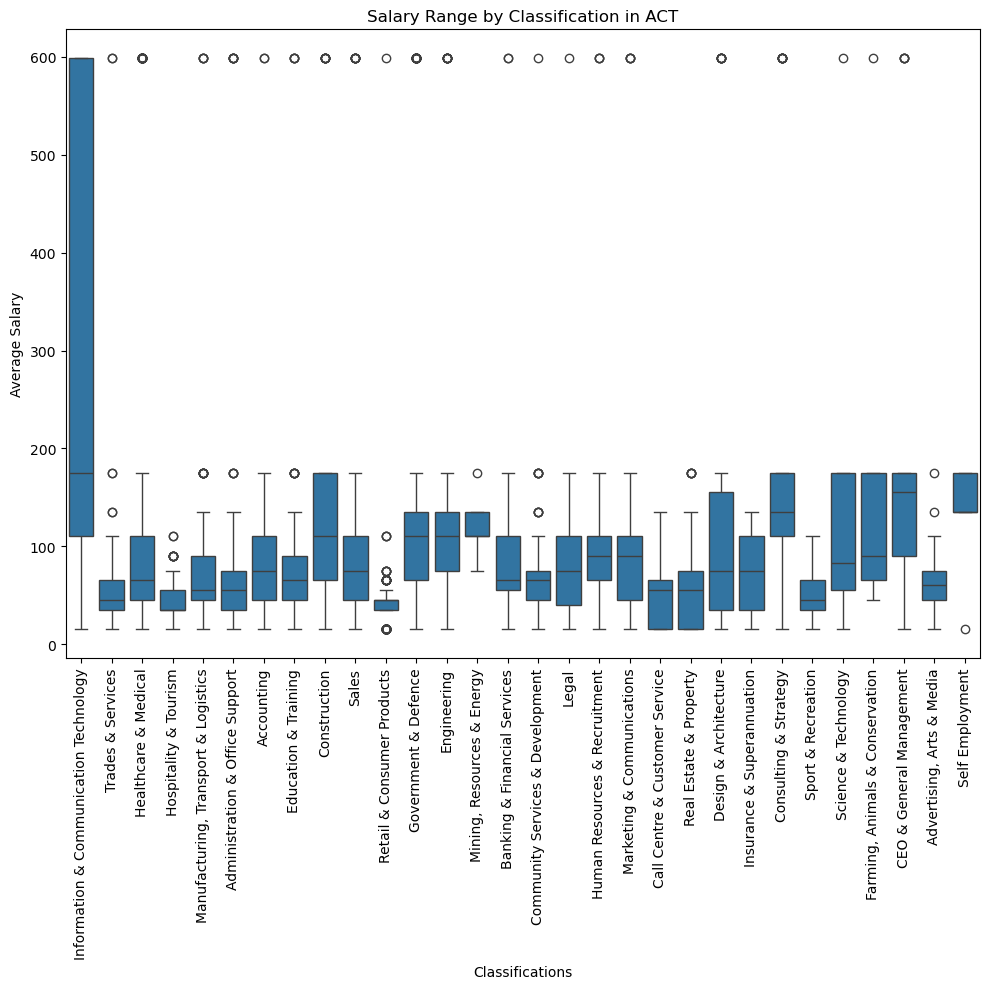

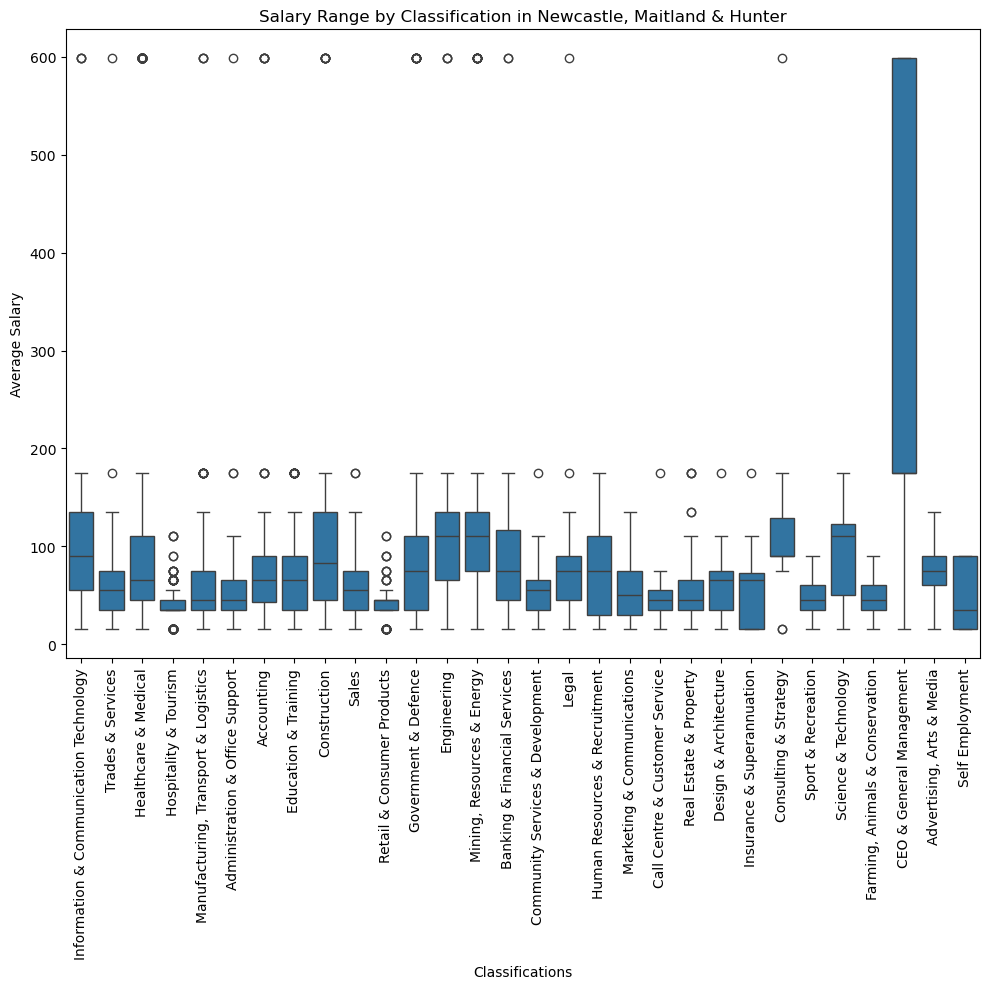

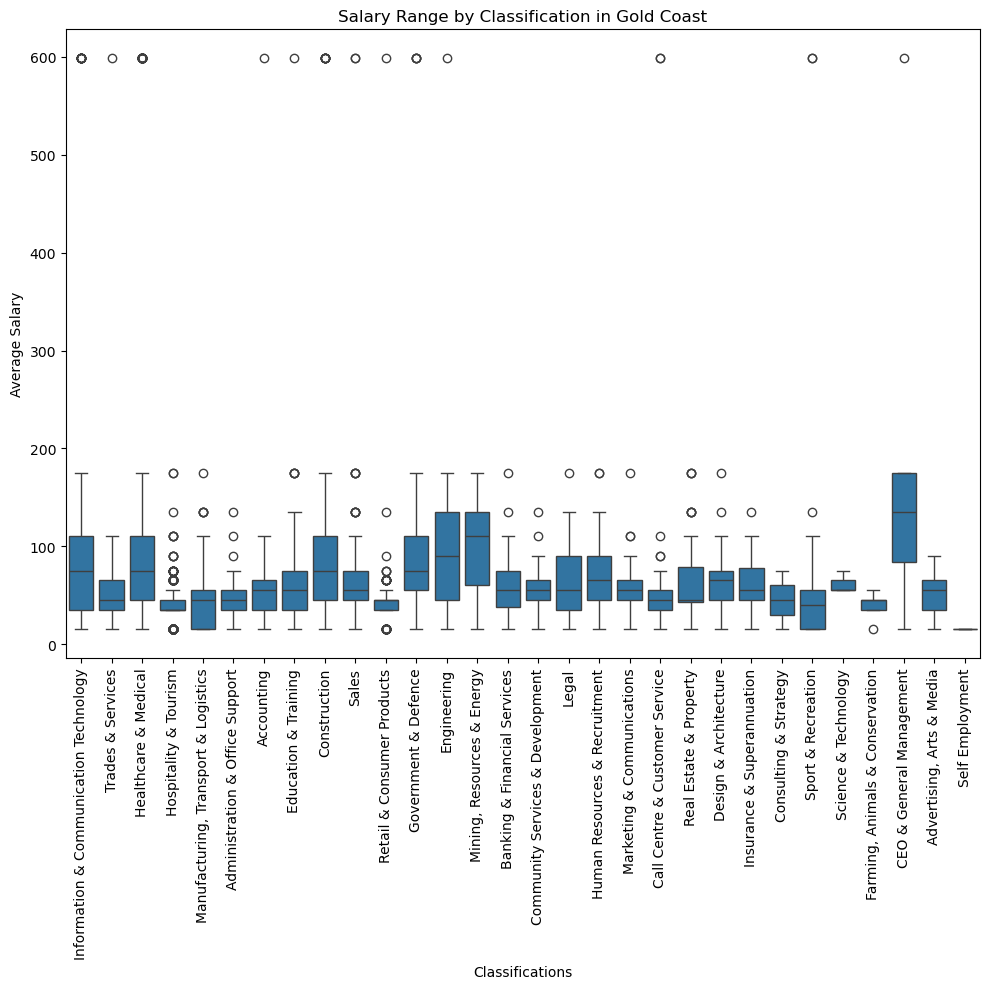

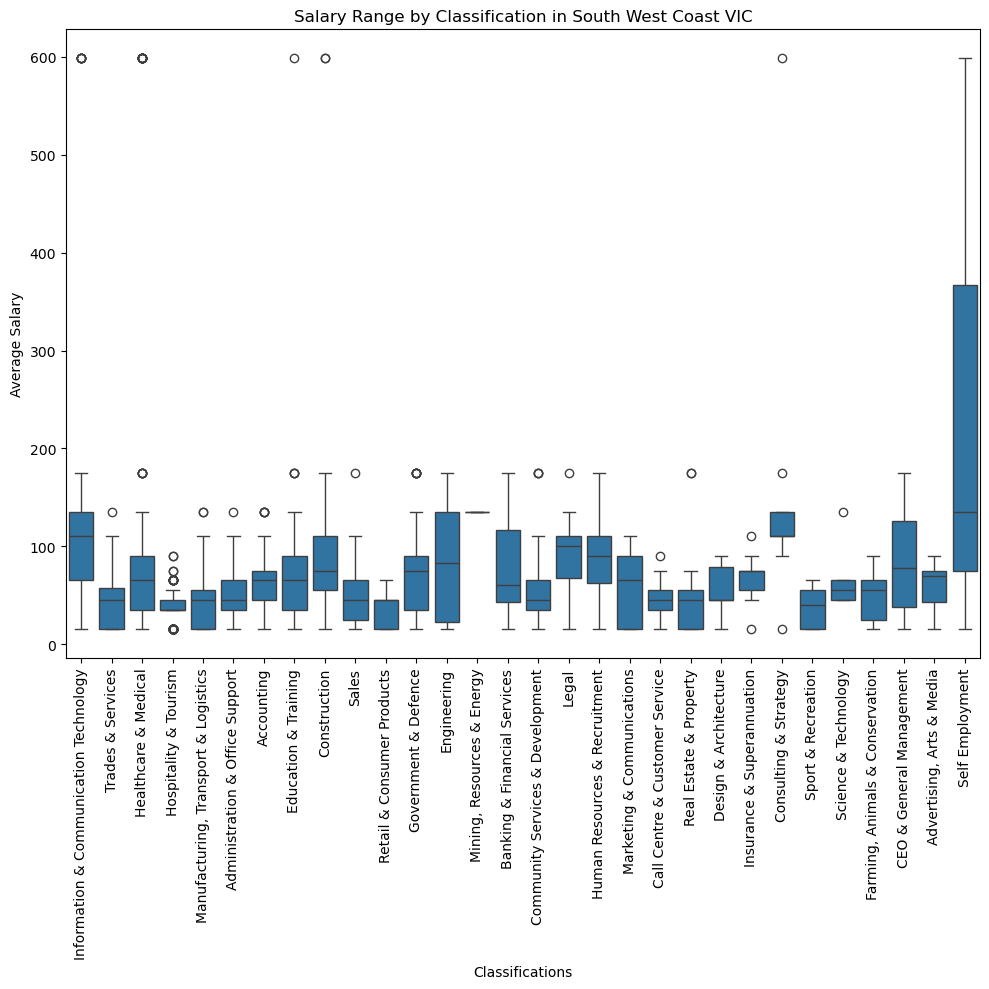

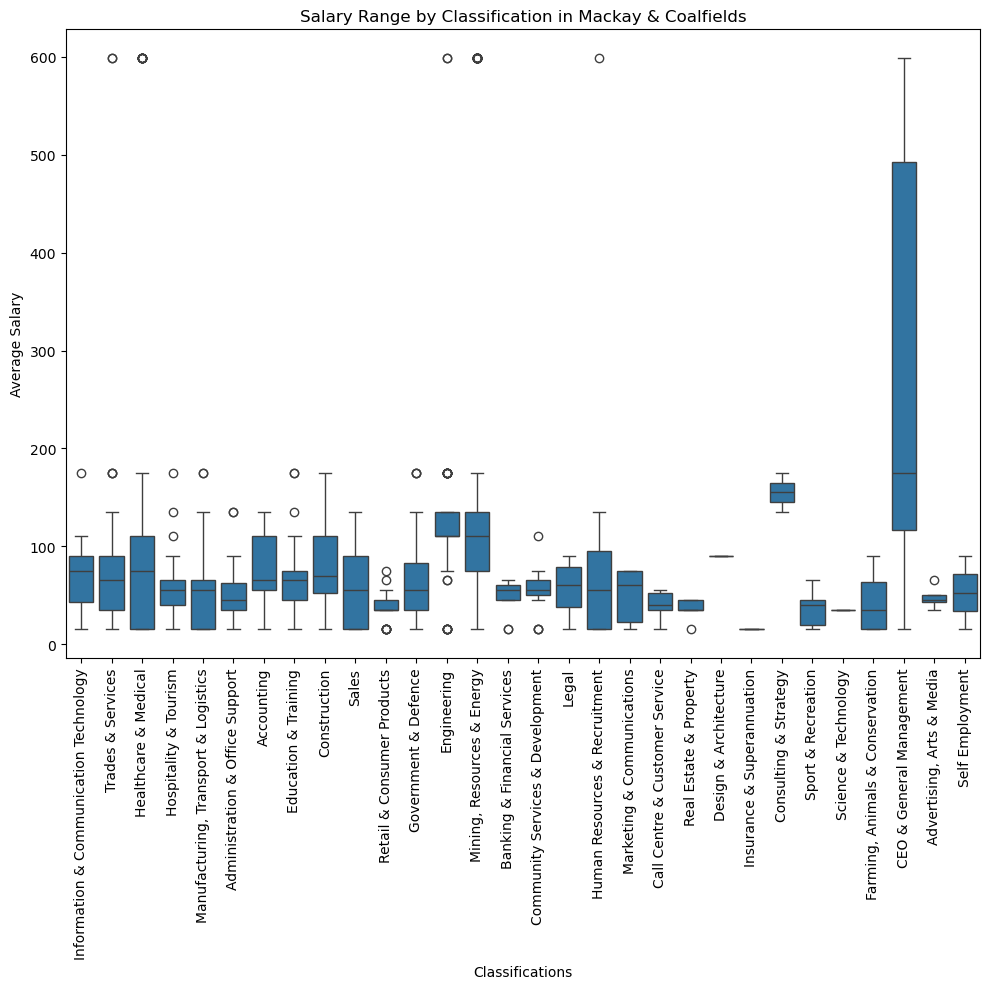

In [24]:
theclassdf = df.groupby('Classification')
classorderdf = pd.DataFrame(theclassdf.size().reset_index(name = "Jobs")).sort_values(by=['Jobs'], ascending=False)
locationDf = df[df['Location'].notna()]
locationCounts = locationDf['Location'].value_counts()
top10locations = locationCounts.head(10).index.tolist()
top10locdf = locationDf[locationDf['Location'].isin(top10locations)]

for location in top10locations:
    plt.figure(figsize=(10, 10))
    location_data = top10locdf[top10locdf['Location'] == location]
    sns.boxplot(data=location_data, x='Classification', y='AverageSalary', order=classorderdf["Classification"])
    plt.title(f'Salary Range by Classification in {location}')
    plt.xlabel('Classifications')
    plt.ylabel('Average Salary')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

CEO & General management are high for Sydney, Melbourne, Brisbane, Newcastle group and Mackay group. This may be due to large companies having headquarters in those regions. This is also bolstered by higher populations allowing for larger working areas, requiring more management. The self employment classification only got to 200k and above for south west Vic, and for ACT. Everywhere else it remained consistently lower. Information and communication technology remained consistently high on average except for ACT where it spiked to 600k for the 75th percentile. Retail and consumer products, and hospitality and tourism consistently have very low average salaries. In general most classifications sit between 150k and 50k salary range. ACT has a noticeably higher average, reaching up until 200k for some classifications which don’t reach 200k in other areas.  


### 2.2.3 Job Posting By Date Analysis

In [25]:
dateDf = df['Date'].value_counts().reset_index()
dateDf.columns = ["Date", "Count"]
dateDf = dateDf.sort_values(by="Date")
dateDf = dateDf.reset_index(drop=True)
period = dateDf[(dateDf["Date"] >= "2018-01-01") & (dateDf["Date"] <= "2020-01-01")]

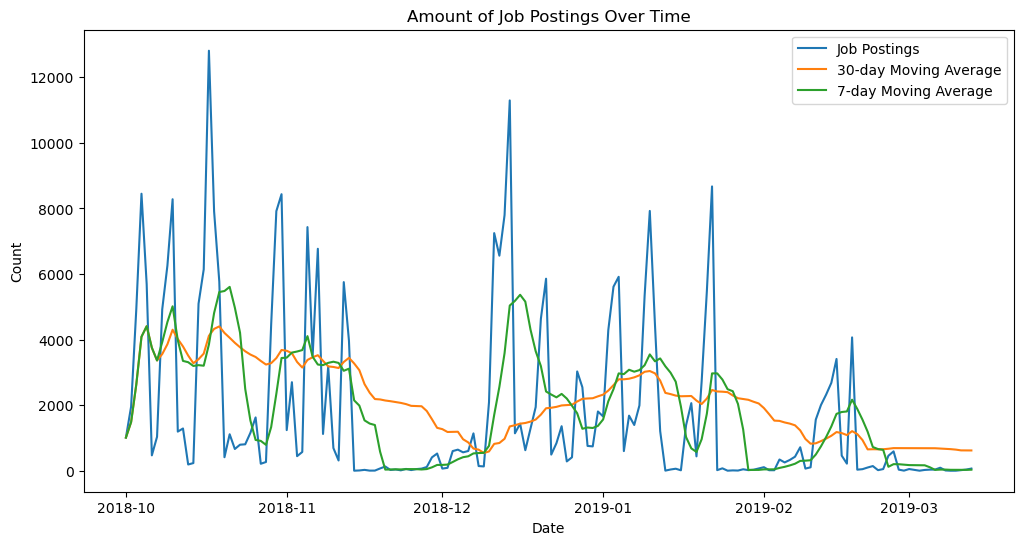

In [26]:
period['Moving_Average30'] = period['Count'].rolling(window=30, min_periods=1).mean()
period['Moving_Average7'] = period['Count'].rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(12,6))
plt.plot(period["Date"], period["Count"], label="Job Postings")
plt.plot(period["Date"], period["Moving_Average30"], label="30-day Moving Average")
plt.plot(period["Date"], period["Moving_Average7"], label="7-day Moving Average")
plt.title("Amount of Job Postings Over Time")
plt.ylabel("Count")
plt.xlabel("Date")
plt.legend()
plt.show()

There is some pattern to when jobs are posted. Over the Christmas period there are very few job postings. There is also a significant drop in job postings over February and march. There is a spike in postings at the end of February and start of march. This might indicate a pattern to job postings where most job postings are posted at the beginning of the month. The spikes and drops during October and November could be explained by the weekend period. Job postings are posted during the weekday as managers are working, then during the weekend there are not as many people working to post the jobs. 

## 2.3 Market By Sectors

### 2.3.1 Sectors By Highest Market Share

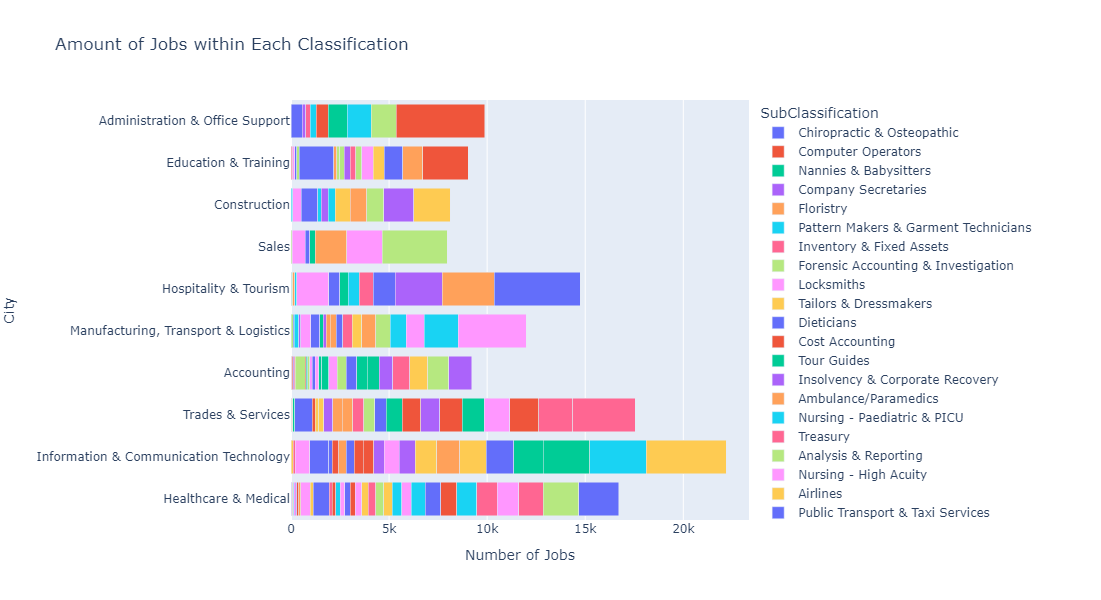

In [27]:
top10class = classDf.head(10)
mergedf = pd.merge(df, top10class[['Count']], left_on='Classification', right_index=True)
csdf = mergedf.groupby(['Classification', 'SubClassification']).size().reset_index(name='Count')
csdf = csdf.sort_values(by='Count', ascending=True)

fig = px.bar(csdf, y='Classification', x='Count', color='SubClassification', title='Amount of Jobs within Each Classification',
             labels={'Count': 'Number of Jobs', 'Classification': 'Classification', 'SubClassification': 'SubClassification'}, barmode='stack')

fig.update_xaxes(title_text='Number of Jobs')
fig.update_yaxes(title_text='City')

fig.update_layout(height=600,  width=1000)
fig.show()

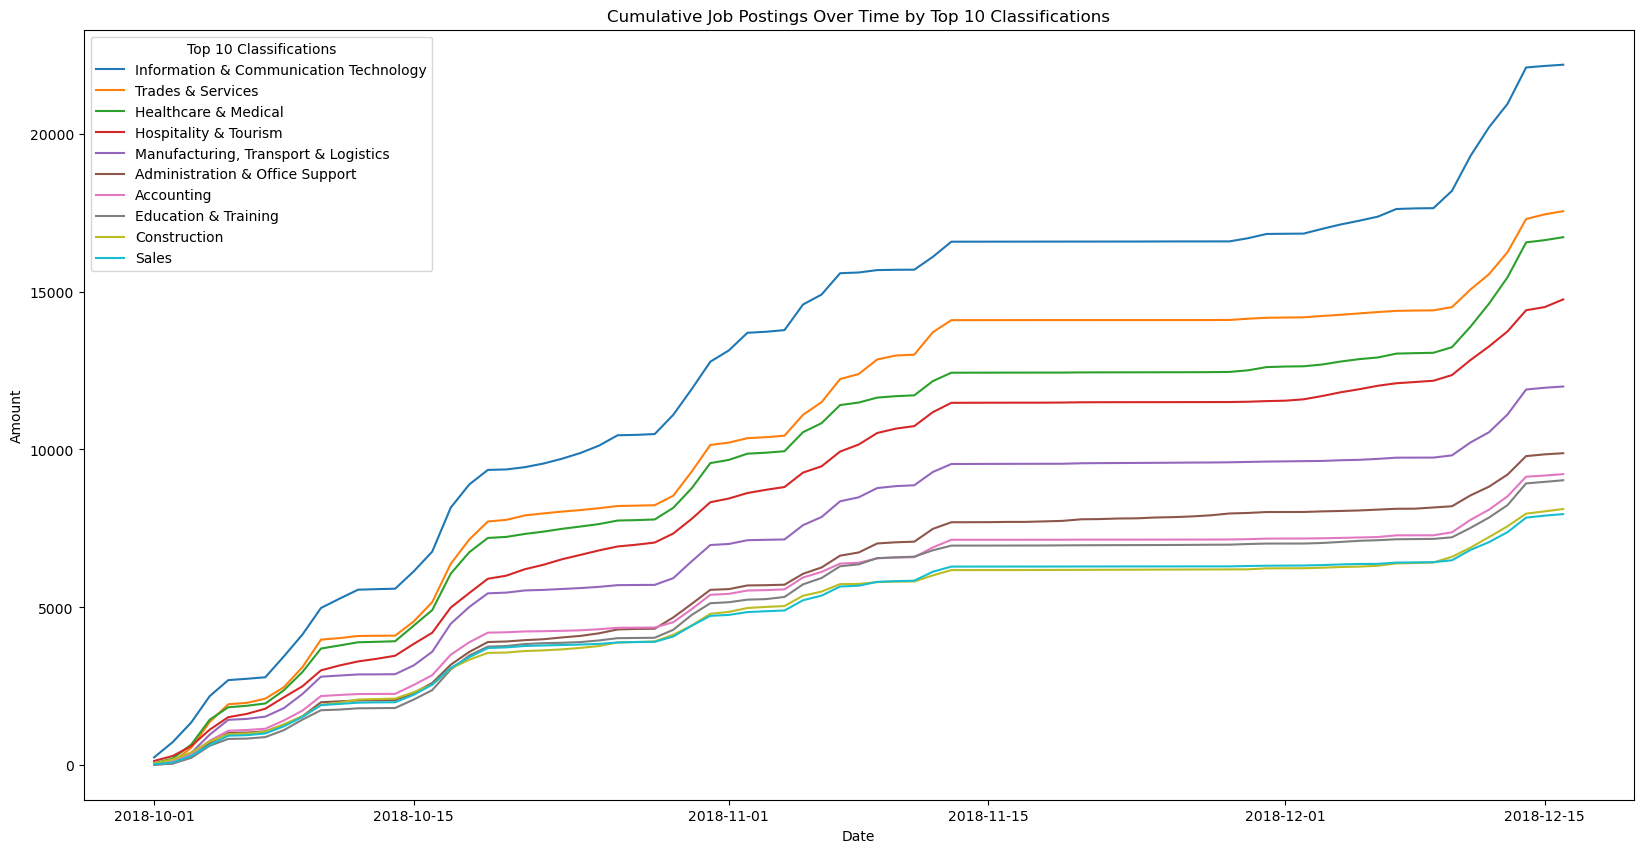

In [28]:
top10class = classorderdf.sort_values(by='Jobs', ascending=False).head(10)['Classification']
postingdf = df[df['Classification'].isna()==False].groupby(['Date', 'Classification'])['Title'].count().reset_index()
postingdf = postingdf[postingdf['Classification'].isin(top10class)]
postingdf = postingdf.groupby(['Classification','Date'])['Title'].sum().groupby(level=0).cumsum().reset_index()
postingdf.columns = ['Classification', 'Date', 'Amount']
postingdf.set_index('Date', inplace=True)

plt.figure(figsize=(20, 10))
classorder = postingdf.groupby('Classification')['Amount'].max().sort_values(ascending=False).index
colors = plt.cm.tab10.colors
for i, c in enumerate(classorder):
    plt.plot(postingdf[postingdf['Classification']==c]['Amount'], label=c, color=colors[i])

plt.title('Cumulative Job Postings Over Time by Top 10 Classifications')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend(title="Top 10 Classifications")

plt.show()

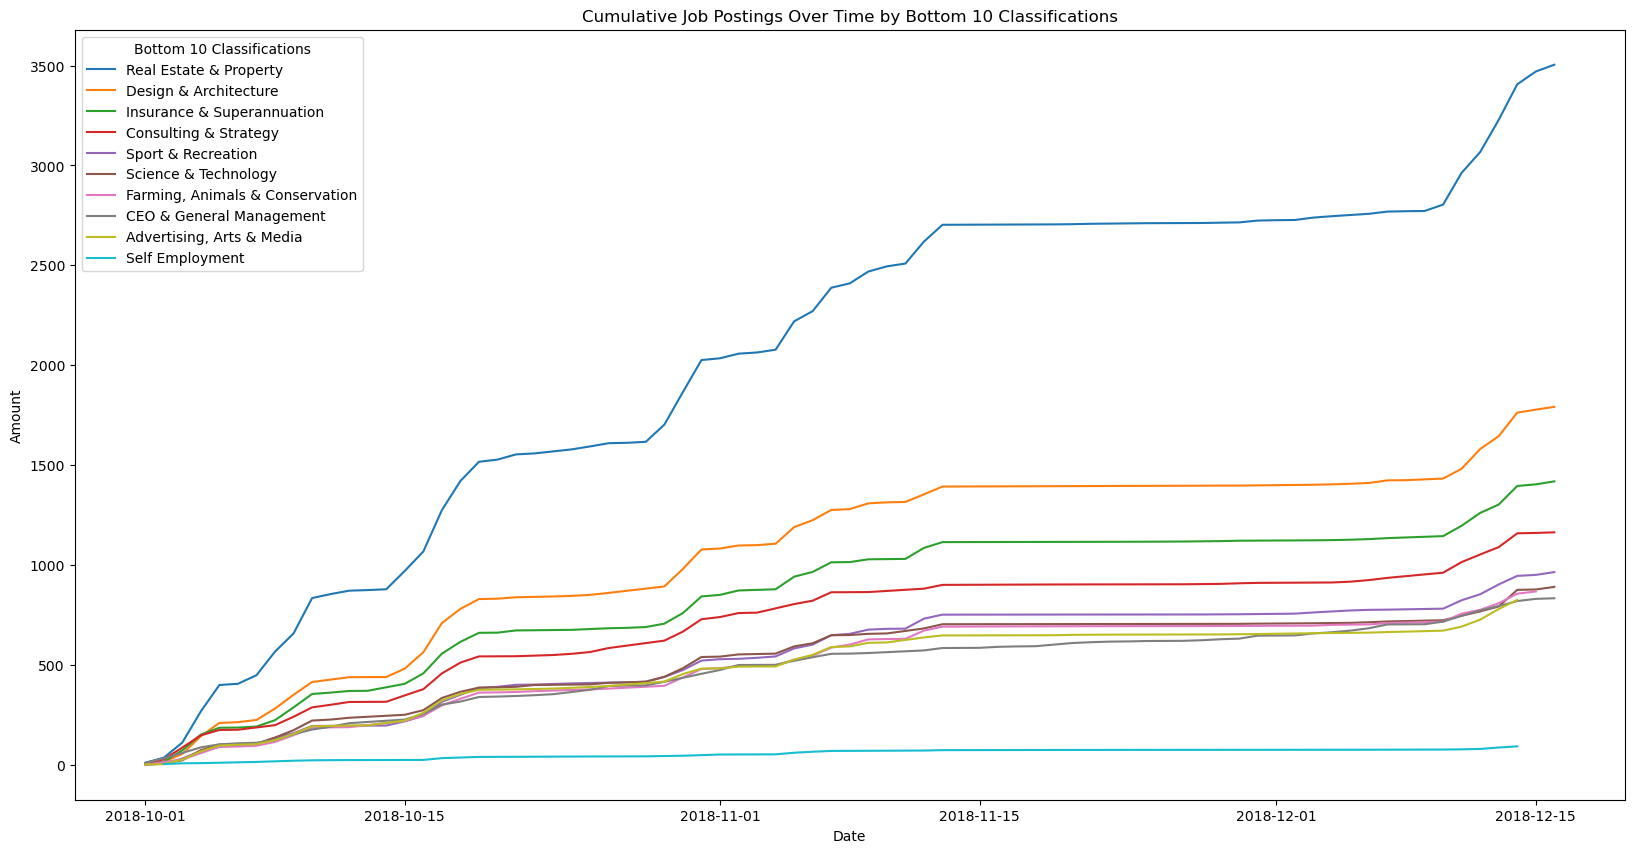

In [29]:
bot10class = classorderdf.sort_values(by='Jobs', ascending=False).tail(10)['Classification']
postingdf = df[df['Classification'].isna()==False].groupby(['Date', 'Classification'])['Title'].count().reset_index()
postingdf = postingdf[postingdf['Classification'].isin(bot10class)]
postingdf = postingdf.groupby(['Classification','Date'])['Title'].sum().groupby(level=0).cumsum().reset_index()
postingdf.columns = ['Classification', 'Date', 'Amount']
postingdf.set_index('Date', inplace=True)

plt.figure(figsize=(20, 10))
classorder = postingdf.groupby('Classification')['Amount'].max().sort_values(ascending=False).index
colors = plt.cm.tab10.colors
for i, c in enumerate(classorder):
    plt.plot(postingdf[postingdf['Classification']==c]['Amount'], label=c, color=colors[i])

plt.title('Cumulative Job Postings Over Time by Bottom 10 Classifications')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend(title="Bottom 10 Classifications")

plt.show()

Throughout each classification contains a period of growth and stagnation, as all classifications tend to stagnate in unison. The stagnation can be classified as an industry trend rather than an isolated classification with low job postings. The graph indicates that jobs belonging to the classifications for “Information & Communication Technology”, “Trades & Services” and “Healthcare & Medical” contain the fastest rate of growth as these classifications either develop future endeavours or are an essential component within our society. Although these classifications produce a higher rate of growth, and these classifications may be strong contenders for future employment prospects. Ultimately securing a job is dependent on whether the individual capabilities will align with the job at hand. 


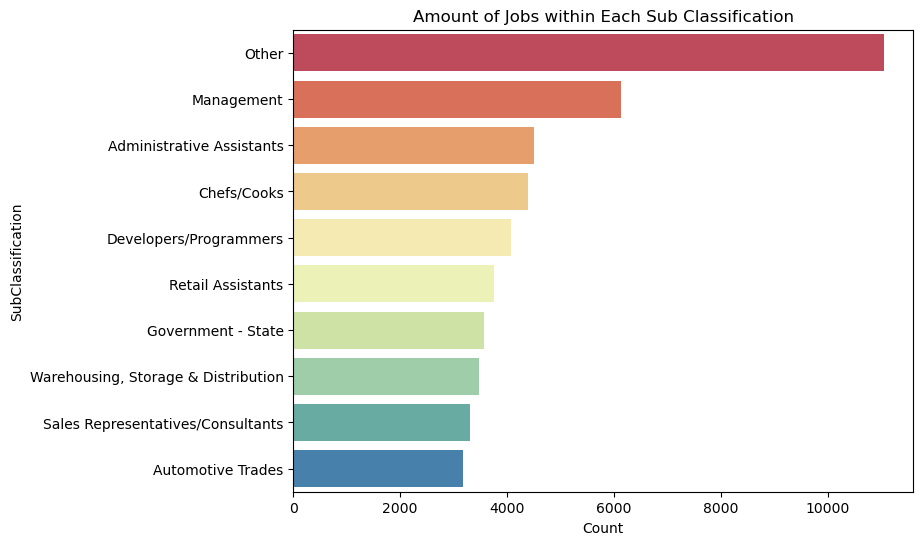

In [30]:
subclassDf = df[df['SubClassification'].isna()==False]
subclassDf = subclassDf.groupby('SubClassification').count()
subclassDf['SubClassification'] = subclassDf.index
subclassDf['Count'] = subclassDf["Title"]
subclassDf.sort_values("Count", ascending=False, inplace=True)
subclassDf10 = subclassDf.head(10)
plt.figure(figsize=(8,6))
sns.barplot(data=subclassDf10, x="Count", y="SubClassification", hue="SubClassification", palette='Spectral')
plt.title("Amount of Jobs within Each Sub Classification")
plt.show()

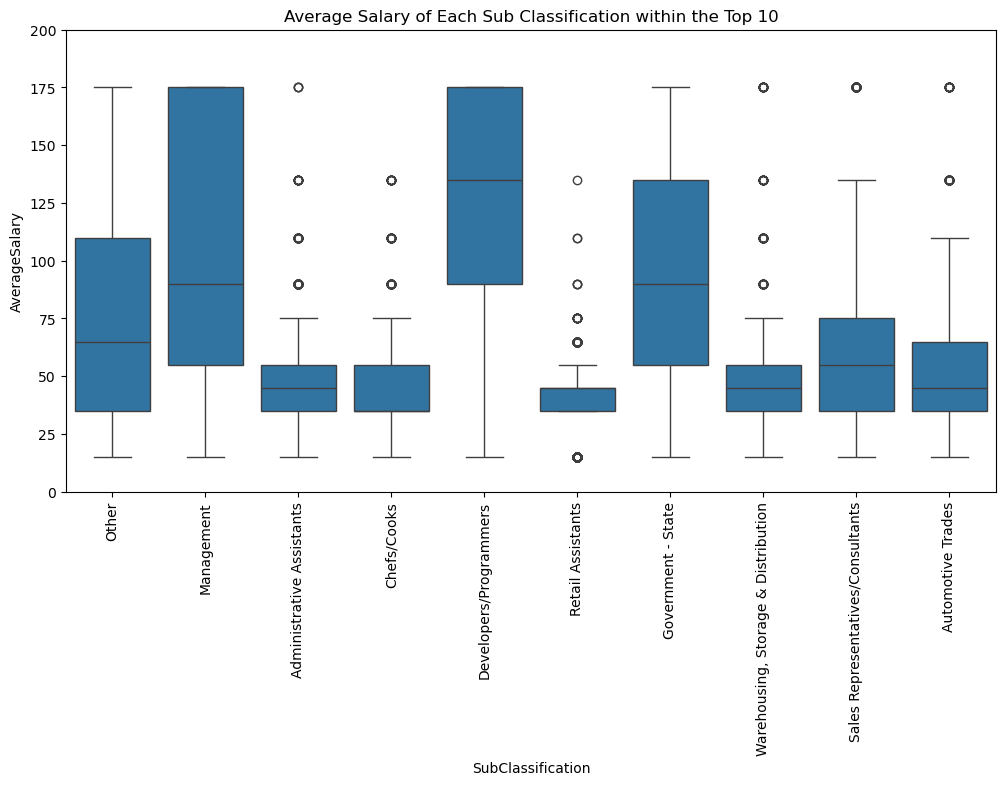

In [31]:
subclasscounts = df['SubClassification'].value_counts().reset_index()
subclasscounts.columns = ['SubClassification', 'JobCount']
top10subclass = subclasscounts.head(10)['SubClassification'].tolist()
subtop10 = df[df['SubClassification'].isin(top10subclass)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=subtop10, x="SubClassification", y="AverageSalary", order=top10subclass)
plt.ylim(0, 200)
plt.xticks(rotation=90)
plt.title("Average Salary of Each Sub Classification within the Top 10")
plt.show()


The above two graphs display the top 10 subclassifications by count, then the average salaries in that order. Management and developers/programmers subclassifications have the highest average salaries. It should be noted that management has a very large range of salaries, from about 60k up to 175k within the first and third quartiles. Retail assistants, administrative assistants, chefs/cooks, warehousing, storage & distribution, automative trades. have the lowest average salaries. Among all other classifications, they are very low on average salary range, below 75k except for a few outliers. Sales representatives lie within the average range of salaries, not very high but not very low either. Government – state subclassification is higher than average but has a wider range of salaries, as low as 50k at the 25th percentile. 

### 2.3.3 Sector Salary Range

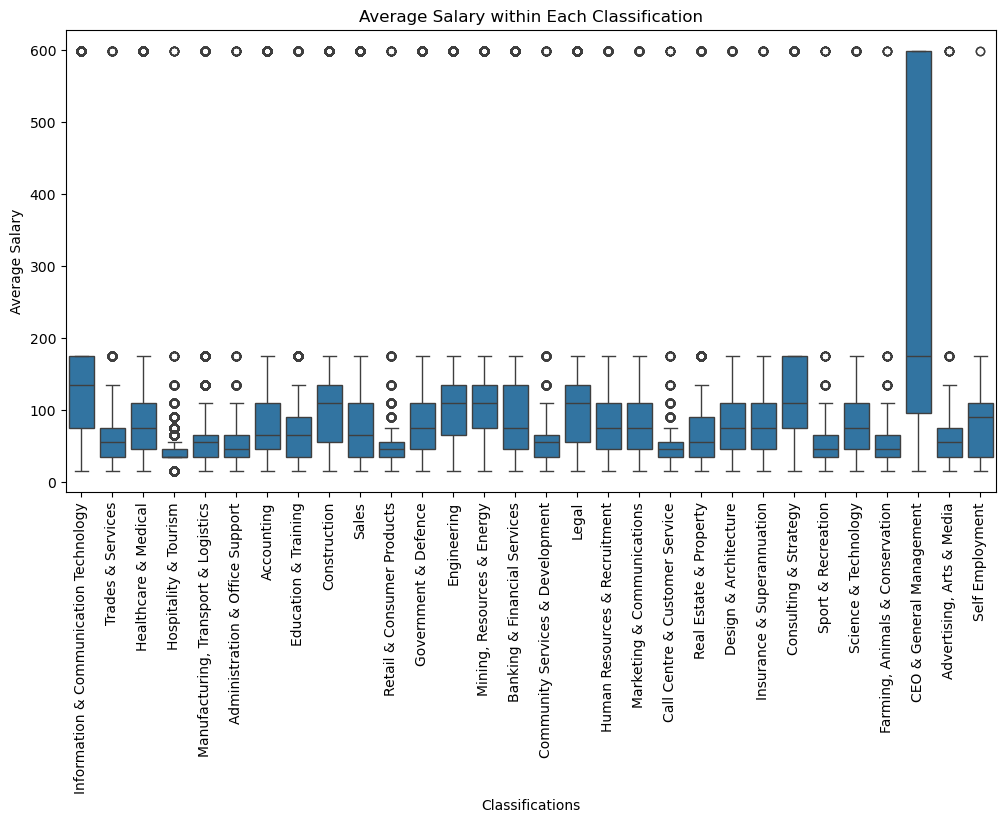

In [32]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="Classification", y="AverageSalary", order=classDf["Classification"])
plt.xticks(rotation=90)
plt.title("Average Salary within Each Classification")
plt.xlabel('Classifications')
plt.ylabel('Average Salary')
plt.show()

The highest quarter value for salary is ACT, which is up to 175k, and has the largest range of salaries. ACT also shared the highest median salary with port Hedland, Karratha & Pilbara, and with Coober Pedy & outback SA. Most locations only have outliers in the 175k salary. Some locations have high 75 percentiles, such as port Hedland, Karratha & Pilbara, Kalgoorlie, Goldfields & Esperance, and Geraldton, Gascoyne & Midwest. All locations with the highest populations, such as Sydney, Melbourne, Brisbane, and Perth, have the same spread of salary. This is despite the differences in cost of living, housing, and other amenities. There are many locations in Australia that have low salaries. In particular, Fleurieu Peninsula & kangaroo Island, Adelaide Hills & Barossa, Yarra Valley & High Country, and Gold Coast all have the 75 percentiles to be under 75k. These locations share a Median and 25 percentile value. It should be noted that Gold Coast was 6th most populated city in Australia containing over 500k people and yet has half the average salary of the 4 largest cities. 

### 2.3.4 Market Trends and Predictions

As Australia continues to develop technologically, the need for IT services will increase. This is the same for the increasing population, which draws larger companies in search of profit. IT service demand will only continue to increase, as will requirements for medical services. As a population grows, so too does the need for medical services. This is especially true for Australia, which has an aging population. Trades & services will always be required for maintenance or construction. As Australia’s population grows, construction and trades will be in greater need, therefore it can be predicted that these classifications will continue to expand. It is uncertain as to the effect of AI on various classifications. AI is already being used regularly in some fields such as legal, administrative positions, and retail. This may lead to fewer positions in these fields in the future, but may open more positions in those fields within different subclassifications. Farming, animals & conservation, sport & recreation, design & architecture, and insurance & superannuation have very few job postings over a 3-month period, with fewer than 4000 postings for each classification. 

### 2.3.5 Sector Skill Requirements

In [33]:
theclassdf = df.groupby('Classification')
classorderdf = pd.DataFrame(theclassdf.size().reset_index(name = "Jobs")).sort_values(by=['Jobs'], ascending=False)
custom_stopwords = ["exciting", "opportunity", "initial", "contract", "term", "edge", "start", "transformation", "government", "organisation", 
                    "profile", "client", "join", "growing", "role", "time", "work", "program", "basis", "scale", "small", "large", "big", "end", 
                    "month", "development", "full", "stack", "week", "great", "friendly", "seeking", "part", "business", "face", "base", "packaging",
                   "day", "rate", "extension", "next", "step", "progression", "dynamic", "progression", "law", "firm", "level", "career"]
stopword = stopwords.words("english")
for word in custom_stopwords:
    stopword.append(word)

In [34]:
def extractskills(tokens):
    skills = []
    tagwords = nltk.pos_tag(tokens)
    for i in range(len(tagwords) - 1):
        if (tagwords[i][1] == 'JJ' and tagwords[i + 1][1] == 'NN') or (tagwords[i][1] == 'NN' and tagwords[i + 1][1] == 'NN') or (tagwords[i][1] == 'VBG' and tagwords[i + 1][1] == 'NN'):
            skills.append(tagwords[i][0] + ' ' + tagwords[i + 1][0])
    return skills

In [35]:
top10class = classorderdf.head(10)["Classification"].tolist()
skillcounts = pd.DataFrame(columns=["Classification", "Skill", "Frequency"])

for classification in top10class:
    skillictdf_class = df[df["Classification"] == classification].copy()
    skillictdf_class["token"] = skillictdf_class.apply(lambda row: nltk.word_tokenize(row["Requirement"]), axis=1)
    skillictdf_class["alpha"] = skillictdf_class["token"].apply(lambda row: [word for word in row if word.isalpha()])
    skillictdf_class["stop"] = skillictdf_class["alpha"].apply(lambda row: [word for word in row if word not in stopword])
    skillictdf_class["tag"] = skillictdf_class["stop"].apply(extractskills)
    
    allskillsclass = [skill for sublist in skillictdf_class["tag"] for skill in sublist]

    skillcountsclass = pd.Series(allskillsclass).value_counts().reset_index()
    skillcountsclass.columns = ["Skill", "Frequency"]
    
    skillcountsclass = skillcountsclass.head(15)
    
    skillcountsclass["Classification"] = classification
    
    skillcounts = pd.concat([skillcounts, skillcountsclass], ignore_index=True)

scaler = MinMaxScaler(feature_range=(100, 1000))
skillcounts["Size"] = scaler.fit_transform(skillcounts[["Frequency"]])

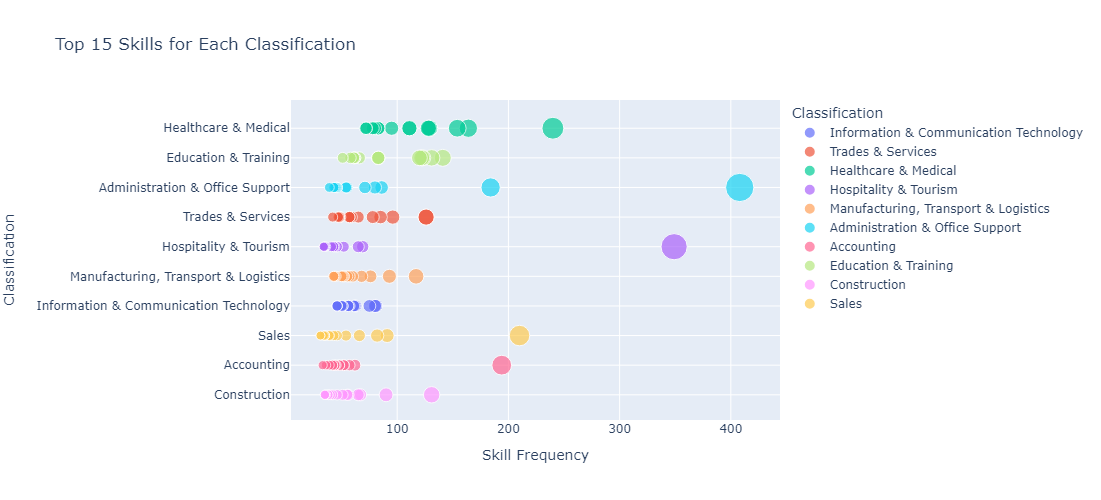

In [36]:
fig = px.scatter(skillcounts, x="Frequency", y="Classification", size="Size", color="Classification",
                 title="Top 15 Skills for Each Classification", labels={"Frequency": "Skill Frequency", "Classification": "Classification"},
                 hover_name="Skill")
fig.update_layout(yaxis=dict(categoryorder='total ascending'), xaxis_title="Skill Frequency", width=1100, height=500)  
fig.show()


Throughout the top skills within each classification, the most predominant skills that span across all classifications are customer service and the ability to work within a team. As majority of the jobs within the top 10 most popular classifications can be classified as office jobs. The importance of working within a team and being able to clearly communicate your ideas is highly favourable. For classifications such as “Administration & Office Support” and “Hospitality & Tourism”, customer service is classified as a crucial to the industry as the job is focused mainly on customers. Leadership is also a demanded skills within many of the classifications as those with predominant leadership skills tend to outperform the average employee. 

## 2.4 Results Visualisation

### 2.4.1 Trend Analysis - Visualisation of Number of Jobs by Locations, Classifications and Subclassifications

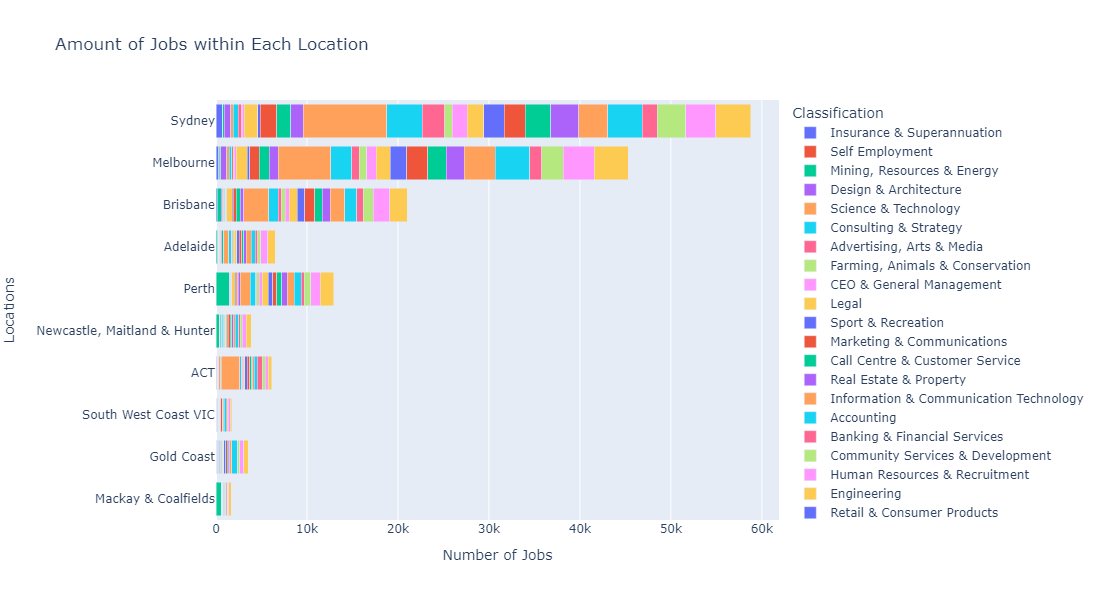

In [37]:
fig = px.bar(lcdf, y='Location', x='Count', color='Classification', title='Amount of Jobs within Each Location',
             labels={'Count': 'Number of Jobs', 'Location': 'Locations', 'Classification': 'Classification'}, barmode='stack')

fig.update_layout(height=600,  width=1150)
fig.show()

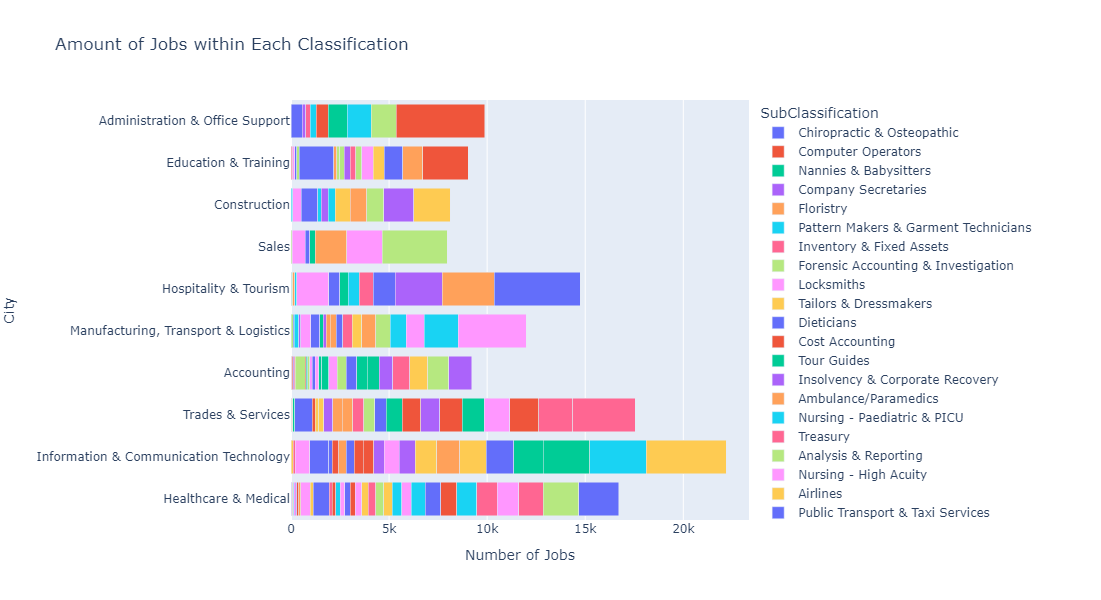

In [38]:
fig = px.bar(csdf, y='Classification', x='Count', color='SubClassification', title='Amount of Jobs within Each Classification',
             labels={'Count': 'Number of Jobs', 'Classification': 'Classification', 'SubClassification': 'SubClassification'}, barmode='stack')

fig.update_xaxes(title_text='Number of Jobs')
fig.update_yaxes(title_text='City')

fig.update_layout(height=600,  width=1000)
fig.show()

### 2.4.2  Sector and Subsector Skill Requirements

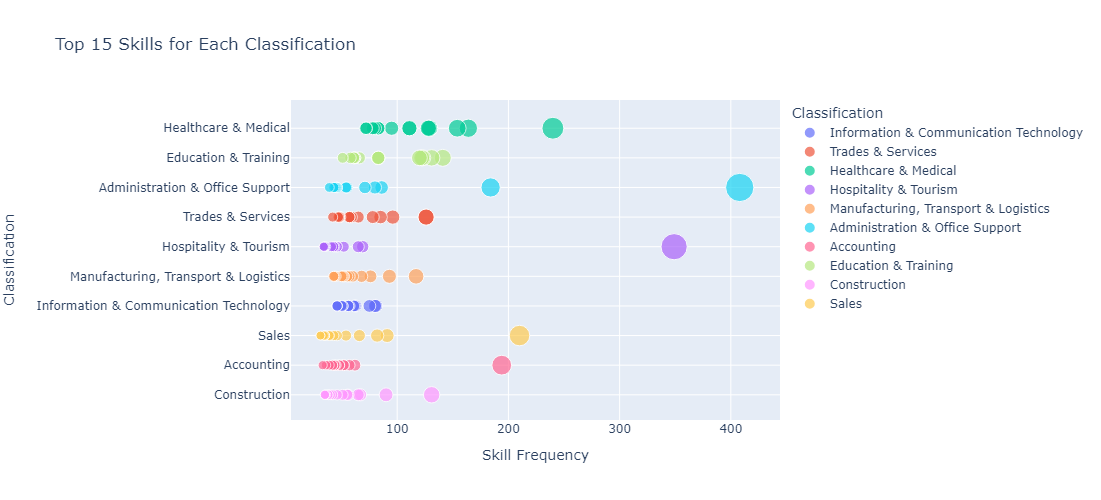

In [39]:
fig = px.scatter(skillcounts, x="Frequency", y="Classification", size="Size", color="Classification",
                 title="Top 15 Skills for Each Classification", labels={"Frequency": "Skill Frequency", "Classification": "Classification"},
                 hover_name="Skill")
fig.update_layout(yaxis=dict(categoryorder='total ascending'), xaxis_title="Skill Frequency", width=1100, height=500)  
fig.show()

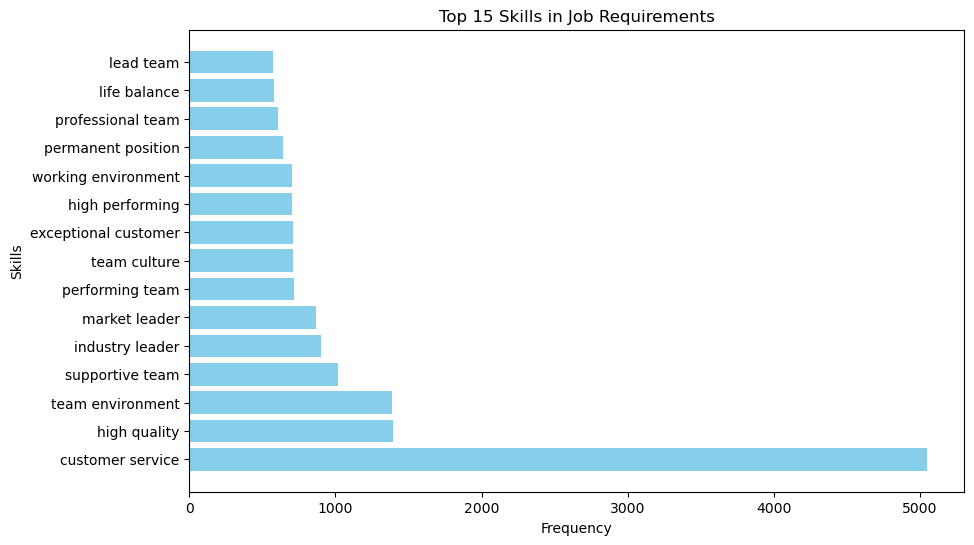

In [41]:
skill_df = df.copy()
skill_df["Requirement"] = skill_df["Requirement"].fillna("")
skill_df["Requirement"] = skill_df["Requirement"].astype(str)

skill_df["token"] = skill_df.apply(lambda row: nltk.word_tokenize(row["Requirement"]), axis=1)
skill_df["alpha"] = skill_df["token"].apply(lambda row: [word for word in row if word.isalpha()])
skill_df["stop"] = skill_df["alpha"].apply(lambda row: [word for word in row if word not in stopword])
skill_df["tag"] = skill_df["stop"].apply(extractskills)

allskills = [skill for sublist in skill_df["tag"] for skill in sublist]

skillcounts = pd.Series(allskills).value_counts().reset_index()
skillcounts.columns = ["Skill", "Frequency"]


top_skillcounts = skillcounts.head(15)


plt.figure(figsize=(10, 6))
plt.barh(top_skillcounts["Skill"], top_skillcounts["Frequency"], color='skyblue')
plt.xlabel("Frequency")
plt.ylabel("Skills")
plt.title("Top 15 Skills in Job Requirements")
plt.show()

Customer service is by far the most required skill across all classifications. It is unlikely to find a classification that does not interact with a client or other people, so people skills are highly sought after. One exception is healthcare and medical, which doesn’t require customer service but does require skills that involve interpersonal interaction. Some other skills also revolve around people skills, including team environment, supportive team, and team culture. In comparison there are only some skill requirements surrounding work quality. 

# Part 3 - Evaluation

## 3.1 Findings

Sydney, Melbourne and Brisbane have the highest number of job postings over the 3 month period. The salary ranged from $75k to $125k between Quartile 1 and 3 at these locations. Gold Coast is the 5th most populated city but has the lowest average salaries, comparable to some small towns. ACT has the highest salary range of all cities, likely due to strong government presence. This is especially true of the information technology classification, which consistently has among the highest salary ranges of all classifications at most locations. Trades and services were consistently in top 3 in job postings as was healthcare and medical. Healthcare and medical has the most subclassifications, however the most popular subclassification aside from “other” was management. The most profitable and popular subclasses are the management and developers/programmers subclasses. The least profitable and most popular subclasses are retail assistants, administrative assistants and chefs/cooks.  

It was discovered that there is likely a weekly pattern to job postings with most job postings occurring during the weekdays. There is also a seasonal pattern, with most job postings occurring during the start or end of a month. Very few job postings occurred during the Christmas period. The skill requirement with the highest number of occurrences is customer service, which is the most demanded skill requirement in most classifications. Following this, general people skills are in high demand particularly in a team environment.  

The sector predicted to grow the most is the information and technology sector due to Australia’s continuing technological development. Other sectors that are likely guaranteed to grow include the medical and trades classifications which are a requirement for maintenance and health. Developments in technology are likely to have a strong impact in many fields, though it is uncertain exactly how severe the impacts will be.

## 3.2 Recommended Actions for Balancing the Markets

Australia has a mostly free market, which means any actions taken to balance the markets should carefully considered. A combination of policy measures, educational initiatives and industry collaborations should be used. In education, vocational training and STEM education can be promoted and made easily accessible will prepare the workforce for future changes in job trends. By promoting higher skilled education, more varied job opportunities will be made available in areas such as manufacturing. It would be beneficial to encourage businesses to set up operations in regions with lower average salaries, such as the gold coast. This will balance job opportunities and wages across various locations, especially regional locations. Incentivising partnerships between educational institutions and various industries can provide students with the skills and experience needed to expand into other job classifications, improving the prevalence of underrepresented fields. 

## 3.3 How Could the Data Analysis be Refined

The analysis of the dataset could be improved with the inclusion of more concrete set of skills rather than a vague request of skills. As this would allow for a more accurate assessment of what skills are better for each classification. Along with information regarding candidates that were successful in their job hunt would also provide useful as these details would help to specific exactly what employers are looking for within their respective industries.  

A more recent set of data would provide more useful, as this information would be more up to date with how the industry is progressing. Alternativity, a longer period of time would also provide improve the extraction of more trends within the job market.  

Additionally, data collected from other websites similar to SEEK, would also expand the current dataset allowing for more trends and accurate analysis of the dataset allowing for more trends and accurate analysis of the dataset.

## 3.4 Implications for Employers and Employees Based on Findings

Utilizing the data collected within the analysis, employees are capable of looking at which skills are most in demand within their respective industry. Using this information, they can tailor their resume into highlighting these skills or focus on building these skills to future expand their capabilities. Employers could also use this information to make sure they are up to date with retrieving the most demanded skills in the industry. Employers and employees could also determine whether their industry is growing and stable. Through these information employers could either increase or decrease the amount of hiring their company is undertaking to more align with the trends to avoid overcompensating or undercompensating. Employees looking to undertake new prospects can determine what classifications provide greater job security to avoid joining classifications that may suffer from a declining future. The number of jobs within each city may be useful to an employee recently joining the industry as they can figure out what locations have the best chance at achieving a job at. Employees are also capable of reviewing whether their current salary is appropriate to their industry and determine whether they are being underpaid. 

# Part 4 - Case Studies

## 4.1 Case Study 1

The top three subclassifications in Information and Communication Technology are developers/programmers, business/systems analysts, and programme & project management. Other notable subclassifications include software engineering, help desk & IT support, and network & systems administration. Of all these subclassifications, developers/programmers have the highest average salary and the highest growing demand. Therefore, it would be wise to pursue employment as a developer/programmer as this has the highest chance of securing employment and providing a good salary. 

The skills to develop for a developer/programmer role includes strong experience in the role, project management experience, and team work skills. Experience can be difficult to cultivate while studying, and it is advised to pursue personal project which can demonstrate your understanding of the field. Python has the highest market share, though a good understanding of object-oriented languages such as Java, C/C++ or C# is recommended. Full stack development is also in high demand, so learning a front end application such as angular is also recommended. Obtaining these skills would allow for application to a very diverse number of job applications, ensuring a higher chance of becoming employed. Diversifying one’s skillset also shows experience in the field which will aid in the employment process. 

Project management experience includes many of the processes of project management, such as the methodologies of sprints. Becoming familiar with various steps in the process of developing an application can make an applicant more appealing to potential employers. Undertaking a project with a team or contributing to open-source software can demonstrate teamwork and dedication to self-improvement, both of which are skills that are in high demand.  

Pursuing a career as a developer/programmer in the ICT sector offers the highest potential for employment due to the strong demand and strong average salary. To improve employability, one should focus on gaining practical experience through personal projects, mastering varied languages such as python and java, and developing a well-rounded skillset demonstrating project management and teamwork skills. Engaging in team-based projects or open-source software can also demonstrate these skills, making candidates more attractive to potential employers.

## 4.2 Case Study 2

The solution can be broken down into multiple parts in order to solve the proposed problem. To begin with, there are a couple of need to knows that much be specified from the employee. Such as the radius within the employee is comfortable travelling to, the employee’s work schedule or whether they are comfortable working from home. This information is vital to the process of finding the top 10 most suitable jobs for an employee, as without this information the employee may need to excuse half of the list just at first glance.  

When selecting an appropriate job market dataset, the dataset best suited to look at is one gathered closely to where the employee is comfortable travelling too. As any locations that is located elsewhere is to be considered irreverent. This data can then be shorted to only containing information within the employee’s job industry. Once the data as been fine-tuned to appropriately related to the employee’s job sector, the process of preprocessing and cleaning will commence. As the main focus of this solution is matching the skills of an employee to multiple job applications, most of the preprocessing and cleaning will focus on the requirements being updated to allow for the process of feature extraction. This process consists of removing punctuation, stop words and performing stemming, lemmatization, or tokenization. 

Once the data have been properly processed, feature extraction will commence. There are multiple ways this can be done such as TF-IDF, bag of words, word embedding and more. This is used to extract the main aspects of the words, which will be later used to match with the employee’s skills. The process of similarity between the job postings skills and the employee’s skills can be achieved either through methods such as cosine similarity or LDA. This will allow for comparison between the skills of the employee and the data to find which are more closely related. 

Once a connection has been made between the employee’s skills and a job’s postings required skills, each postings will now be able to be ranked in order to how compatible they are with the employee. With the jobs with the most similarity at the top and the bottom containing the least. The system will then be able to provide the employee with their top 10 most recommended jobs.  

For future evaluations of other employees, surveys could be undertaken by the employee after they have been provided with their top 10 jobs. As this would be beneficial in determining the issues and positives of the systems to either improve on or entirely changed certain aspects. An expansion of a dataset including more information to determine the reputation of a job as well as determine whether a posting has reasonable job security. As this will provide the employee with more reinsurance within the system.